In [1]:
import datetime as dt
import os
import re
import numpy as np
from mintpy.utils import ptime

In [2]:
def read_ionex(tec_file):
    """Read TEC file in IONEX format.

    Parameters: tec_file - str, path to the TEC file in IONEX format
    Returns:    mins     - 1D np.ndarray in size of (num_map), time of the day in minutes
                lats     - 1D np.ndarray in size of (num_lat), latitude  in degrees
                lons     - 1D np.ndarray in size of (num_lon), longitude in degrees
                tec_maps - 3D np.ndarray in size of (num_map, num_lat, num_lon), vertical TEC in TECU
                rms_maps - 3D np.ndarray in size of (num_map, num_lat, num_lon), vertical TEC RMS in TECU
    Examples:   tec_dir = os.path.expanduser('~/data/aux/IONEX')
                tec_file = get_ionex_filename('20190519', tec_dir=tec_dir, sol_code='jpl')
                mins, lats, lons, tec_maps = read_ionex(tec_file)[:4]
    """

    # functions for parsing ionex file
    # link: https://github.com/daniestevez/jupyter_notebooks/blob/master/IONEX.ipynb
    def parse_map(tec_map, key='TEC', exponent=-1):
        tec_map = re.split(f'.*END OF {key} MAP', tec_map)[0]
        tec_map = [np.fromstring(x, sep=' ') for x in re.split('.*LAT/LON1/LON2/DLON/H\\n', tec_map)[1:]]
        return np.stack(tec_map) * 10**exponent

    # read IONEX file
    with open(tec_file) as f:
        fc = f.read()

        # read header
        header = fc.split('END OF HEADER')[0].split('\n')
        for line in header:
            if line.strip().endswith('# OF MAPS IN FILE'):
                num_map = int(line.split()[0])
            elif line.strip().endswith('DLAT'):
                lat0, lat1, lat_step = (float(x) for x in line.split()[:3])
            elif line.strip().endswith('DLON'):
                lon0, lon1, lon_step = (float(x) for x in line.split()[:3])
            elif line.strip().endswith('EXPONENT'):
                exponent = float(line.split()[0])

        # spatial coordinates
        num_lat = int((lat1 - lat0) / lat_step + 1)
        num_lon = int((lon1 - lon0) / lon_step + 1)
        lats = np.arange(lat0, lat0 + num_lat * lat_step, lat_step)
        lons = np.arange(lon0, lon0 + num_lon * lon_step, lon_step)

        # time stamps
        min_step = 24 * 60 / (num_map)
        mins = np.arange(0, num_map * min_step, min_step)

        # read TEC and its RMS maps
        tec_maps = np.array([parse_map(t, key='TEC', exponent=exponent)
                             for t in fc.split('START OF TEC MAP')[1:]], dtype=np.float32)

    return mins, lats, lons, tec_maps

In [3]:
mins, lat, lon, tec_maps = read_ionex('USATEC1250.GIM.INX')

In [4]:
lat=lat[6:]
tec_maps = tec_maps[:,6:,:]

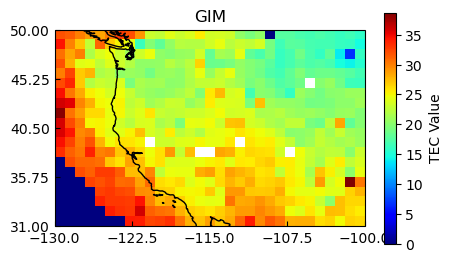

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(5, 3))
ax = plt.axes(projection=ccrs.PlateCarree())

# 绘制图像
im = ax.imshow(tec_maps[6, :, :], cmap='jet', origin='lower',
               extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               transform=ccrs.PlateCarree())

# 添加海岸线
ax.add_feature(cfeature.COASTLINE)

# 设置坐标轴刻度向内
ax.tick_params(axis='both', direction='in')


# 设置横纵坐标轴刻度
ax.set_xticks(np.linspace(lon.min(), lon.max(), 5))
ax.set_yticks(np.linspace(lat.min(), lat.max(), 5))

# 添加颜色条
plt.colorbar(im, ax=ax, label='TEC Value')

plt.title('GIM')
plt.show()

## 做一个插值

In [6]:
import numpy as np
from scipy.interpolate import griddata

data = tec_maps[6, :, :]
# 获取非零且非NaN值的索引
valid_indices = ~np.isnan(data) & (data!= 0)
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
points = np.array([x[valid_indices], y[valid_indices]]).T
values = data[valid_indices]

# 对整个网格进行插值
interpolated_data = griddata(points, values, (x, y), method='linear')

# 用插值后的数据替换原数据中的0和NaN值
tec_maps[6, :, :] = np.where(valid_indices, data, interpolated_data)

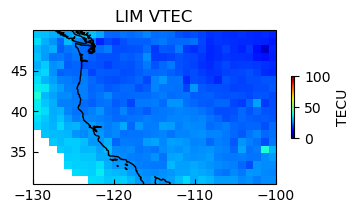

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 创建地图投影
plt.figure(figsize=(4, 2))
ax = plt.axes(projection=ccrs.PlateCarree())

# 绘制图像
im = ax.imshow(tec_maps[6, :, :], cmap='jet', origin='lower',
               extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               transform=ccrs.PlateCarree(),vmax=100,vmin=0)

# 添加海岸线
ax.add_feature(cfeature.COASTLINE)

# 设置坐标轴刻度向内
ax.tick_params(axis='both', direction='in')

# 设置横纵坐标轴刻度
ax.set_xticks(np.linspace(-130,-100,4))
ax.set_yticks(np.linspace(35,45,3))

# 添加颜色条
plt.colorbar(im, ax=ax, label='TECU', shrink=0.4)
plt.title('LIM VTEC')

plt.savefig('LIM.png', bbox_inches='tight', transparent=True, dpi=600)
plt.show()